In [139]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

In [32]:
sklearn.__version__

'0.24.1'

# CR

In [176]:
df = pd.read_csv(r"C:\HSE\genotek\CR_graph_rel.csv")
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_5,мордвины,мордвины,29.81720,4
1,node_0,node_10,мордвины,мордвины,11.63220,1
2,node_0,node_11,мордвины,мордвины,23.90440,2
3,node_0,node_18,мордвины,мордвины,11.25290,1
4,node_0,node_20,мордвины,мордвины,8.88252,1
...,...,...,...,...,...,...
67498,node_3741,node_3752,белорусы,белорусы,9.51327,1
67499,node_3745,node_3755,белорусы,белорусы,9.23221,1
67500,node_3749,node_3764,белорусы,белорусы,10.63310,1
67501,node_3754,node_3755,украинцы,белорусы,8.04722,1


In [172]:
len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())

3767

## Get distribution

In [177]:
nodes_names = set()
all_types_dict = {}

types = df['label_id1'].unique().tolist()

for t in types:
    all_types_dict[t] = 0

for i, n in enumerate(df['node_id1']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id1'][i]] += 1
        
for i, n in enumerate(df['node_id2']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id2'][i]] += 1
        
print(all_types_dict)

{'мордвины': 70, 'белорусы': 463, 'украинцы': 426, 'южные-русские': 2177, 'северные-русские': 631}


## Training and results

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        46
           1       0.31      0.60      0.41       276
           2       0.23      0.86      0.37       253
           3       0.94      0.51      0.66      1405
           4       0.89      0.32      0.47       409

    accuracy                           0.52      2389
   macro avg       0.67      0.47      0.40      2389
weighted avg       0.78      0.52      0.56      2389



<Figure size 432x288 with 0 Axes>

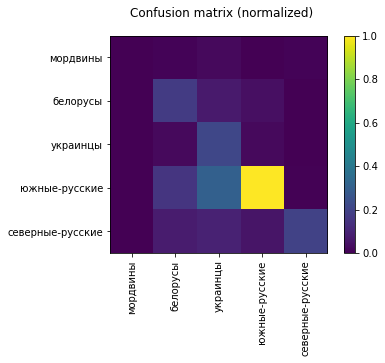

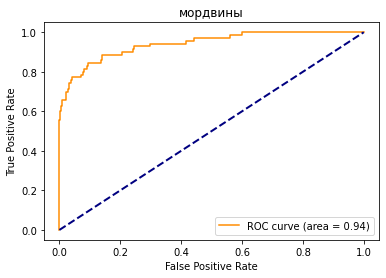

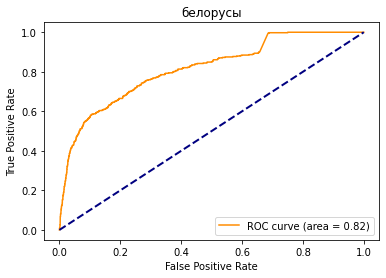

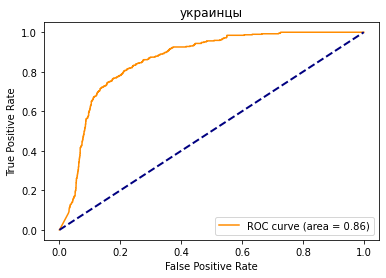

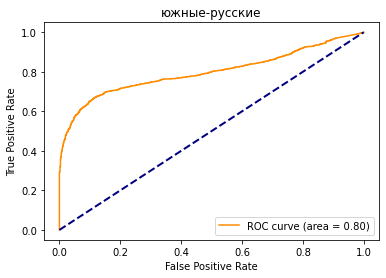

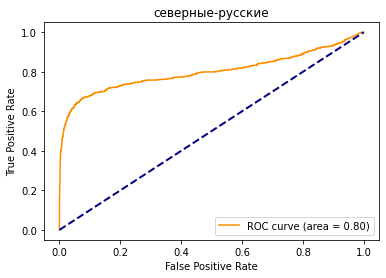

In [157]:
def get_dataset(df, cond):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    nodes_dict = {}
    
    for i, n in enumerate(df['node_id1']):
        if n in nodes_dict.keys():
            nodes_dict[n][0][df['label_id2'][i]] += df['ibd_sum'][i]
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                id_ = types.index(df['label_id1'][i])
                current_types_dict[df['label_id1'][i]] += 1
            else:
                id_ = -1
            nodes_dict[n] = [types_dict.copy(), id_]
        
    return nodes_dict

data = get_dataset(df, 0.35) # second number - the part of training data

inputs = [list(i[0].values()) for i in list(data.values())]
targets = [i[1] for i in list(data.values())]

def rbf_kernel_safe(X, Y=None, gamma=None): 

    X, Y = sklearn.metrics.pairwise.check_pairwise_arrays(X, Y) 
    if gamma is None: 
        gamma = 1.0 / X.shape[1] 

    K = sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True) 
    K *= -gamma 
    K -= K.max()
    np.exp(K, K)    # exponentiate K in-place 
    return K 

label_prop_model = LabelSpreading(kernel='knn', n_neighbors=200, max_iter=1000, tol=1e-3, n_jobs=-1, gamma=0.001)
label_prop_model.fit(inputs, targets)
predicted = label_prop_model.predict(inputs)

unlabeled_targets = np.array(targets) == -1

data = get_dataset(df, 2) # second number - whatever number > 1 because we need to select all data

targets = np.array([i[1] for i in list(data.values())])

print(classification_report(targets[unlabeled_targets], predicted[unlabeled_targets]))

cm = confusion_matrix(targets, predicted, labels=label_prop_model.classes_)

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(cm/np.max(cm))
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(all_types_dict.keys(), rotation = 90)
ax.set_yticks([i for i in range(5)])
ax.set_yticklabels(all_types_dict.keys())
fig.colorbar(img)
fig.suptitle("Confusion matrix (normalized)")
plt.savefig(r"C:\HSE\genotek\cm_cr.png", bbox_inches="tight")
plt.show()

for i in range(5):
    fpr, tpr, _ = metrics.roc_curve(targets,  label_prop_model.predict_proba(inputs)[:, i], pos_label=i)

    plt.clf()
    plt.title(list(all_types_dict.keys())[i])
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr), color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(rf"C:\HSE\genotek\roc_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()

[How to get rbf_kernel_safe](https://stackoverflow.com/questions/52057836/labelpropagation-how-to-avoid-division-by-zero)

# NC

In [174]:
df = pd.read_csv(r"C:\HSE\genotek\NC_graph_rel.csv")
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_1,чеченцы,чеченцы,9.76537,1
1,node_0,node_13,чеченцы,чеченцы,26.49970,3
2,node_0,node_15,чеченцы,чеченцы,8.31678,1
3,node_0,node_594,чеченцы,чеченцы,8.64458,1
4,node_1,node_8,чеченцы,чеченцы,8.14209,1
...,...,...,...,...,...,...
6292,node_624,node_629,ингуши,осетины,11.24220,1
6293,node_624,node_630,ингуши,чеченцы,14.70900,2
6294,node_625,node_628,осетины,осетины,8.26460,1
6295,node_625,node_629,осетины,осетины,8.91348,1


In [169]:
len(pd.concat([df['node_id1'], df['node_id2']], axis=0).unique())

614

## Get distribution

In [175]:
nodes_names = set()
all_types_dict = {}

types = df['label_id1'].unique().tolist()

for t in types:
    all_types_dict[t] = 0

for i, n in enumerate(df['node_id1']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id1'][i]] += 1
        
for i, n in enumerate(df['node_id2']):
    if n not in nodes_names:
        nodes_names.add(n)
        all_types_dict[df['label_id2'][i]] += 1
        
print(all_types_dict)

{'чеченцы': 95, 'кабардинцы,черкесы,адыгейцы': 148, 'карачаевцы,балкарцы': 86, 'ингуши': 52, 'дагестанские народы': 134, 'осетины': 52, 'кумыки': 18, 'ногайцы': 29}


## Training and results

              precision    recall  f1-score   support

           0       0.87      0.74      0.80        27
           1       0.95      0.46      0.62        41
           2       0.96      0.92      0.94        25
           3       0.76      0.81      0.79        16
           4       0.52      0.97      0.67        31
           5       0.65      0.73      0.69        15
           6       0.17      0.20      0.18         5
           7       1.00      0.29      0.44         7

    accuracy                           0.71       167
   macro avg       0.73      0.64      0.64       167
weighted avg       0.79      0.71      0.71       167

[[ 84   0   0   4   2   0   2   0]
 [  2 115   1   0  17   5   0   0]
 [  0   1  78   0   3   1   1   0]
 [  0   1   0  48   1   0   2   0]
 [  0   1   0   0 104   0   1   0]
 [  0   1   2   0   3  44   0   0]
 [  1   0   0   0   3   0  10   0]
 [  0   0   0   0   8   0   0  14]]


<Figure size 432x288 with 0 Axes>

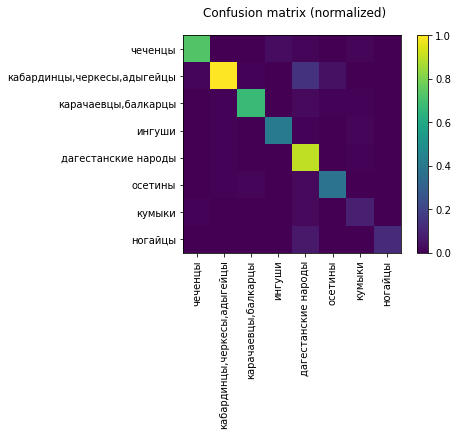

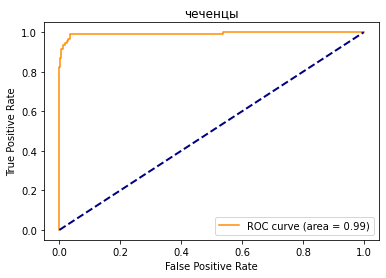

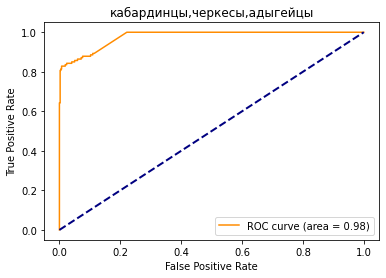

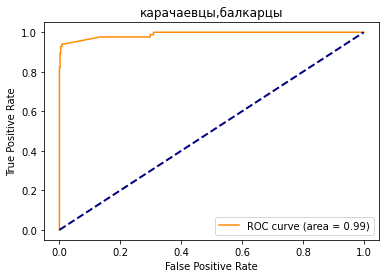

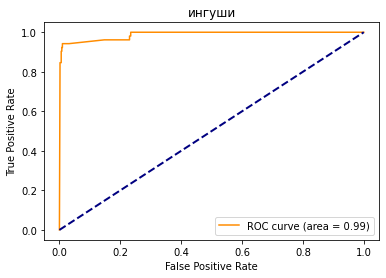

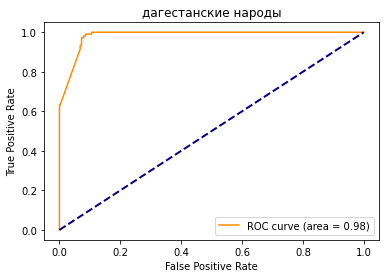

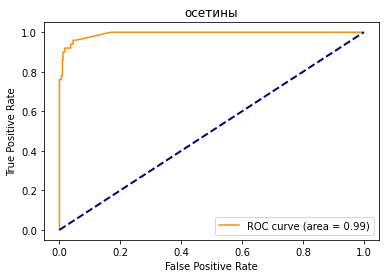

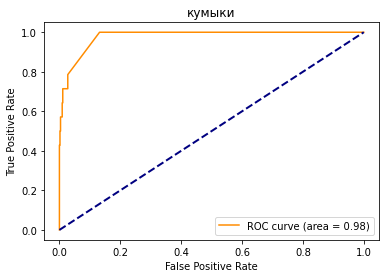

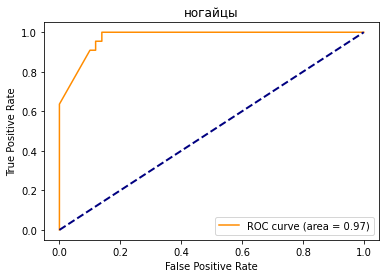

In [163]:
def get_dataset(df, cond):
    types = df['label_id1'].unique().tolist()
    types_dict = {}

    for t in types:
        types_dict[t] = 0

    current_types_dict = types_dict.copy()

    nodes_dict = {}
    
    for i, n in enumerate(df['node_id1']):
        if n in nodes_dict.keys():
            nodes_dict[n][0][df['label_id2'][i]] += df['ibd_sum'][i]
        else:
            if (current_types_dict[df['label_id1'][i]] + 1) / all_types_dict[df['label_id1'][i]] < cond:
                id_ = types.index(df['label_id1'][i])
                current_types_dict[df['label_id1'][i]] += 1
            else:
                id_ = -1
            nodes_dict[n] = [types_dict.copy(), id_]
        
    return nodes_dict

data = get_dataset(df, 0.71) # second number - the part of training data

inputs = [list(i[0].values()) for i in list(data.values())]
targets = [i[1] for i in list(data.values())]

def rbf_kernel_safe(X, Y=None, gamma=None): 

    X, Y = sklearn.metrics.pairwise.check_pairwise_arrays(X, Y) 
    if gamma is None: 
        gamma = 1.0 / X.shape[1] 

    K = sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True) 
    K *= -gamma 
    K -= K.max()
    np.exp(K, K)    # exponentiate K in-place 
    return K 

label_prop_model = LabelSpreading(kernel=rbf_kernel_safe, max_iter=1000, tol=1e-3, n_jobs=-1, gamma=200)
label_prop_model.fit(inputs, targets)
predicted = label_prop_model.predict(inputs)

unlabeled_targets = np.array(targets) == -1

data = get_dataset(df, 2) # second number - whatever number > 1 because we need to select all data

targets = np.array([i[1] for i in list(data.values())])

print(classification_report(targets[unlabeled_targets], predicted[unlabeled_targets]))

cm = confusion_matrix(targets, predicted, labels=label_prop_model.classes_)
print(cm)

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(cm/np.max(cm))
ax.set_xticks([i for i in range(8)])
ax.set_xticklabels(all_types_dict.keys(), rotation = 90)
ax.set_yticks([i for i in range(8)])
ax.set_yticklabels(all_types_dict.keys())
fig.colorbar(img)
fig.suptitle("Confusion matrix (normalized)")
plt.savefig(r"C:\HSE\genotek\cm_nc.png", bbox_inches="tight")
plt.show()

for i in range(8):
    fpr, tpr, _ = metrics.roc_curve(targets,  label_prop_model.predict_proba(inputs)[:, i], pos_label=i)

    plt.clf()
    plt.title(list(all_types_dict.keys())[i])
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr), color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(rf"C:\HSE\genotek\roc_{list(all_types_dict.keys())[i]}.png", bbox_inches="tight")
    plt.show()